# Paper: Optimizing Temperature for Language Models with Multi-Sample Inference

**Arxiv link**: https://arxiv.org/pdf/2502.05234

# Vocabulary

**1. Sampling Temperature**
   - Controls the randomness of model output. Lower temperature = more deterministic, higher = more random.
   - Applied by dividing the logits by the temperature before passing through softmax to get the next-token probability.

| Use Case                 | Temperature | Top_p | Description                                                                                  |
|--------------------------|-------------|-------|----------------------------------------------------------------------------------------------|
| Code Generation           | 0.2         | 0.1   | Generates code that adheres to established patterns and conventions. Output is more deterministic and focused. Useful for generating syntactically correct code. |
| Creative Writing          | 0.7         | 0.8   | Generates creative and diverse text for storytelling. Output is more exploratory and less constrained by patterns. |
| Chatbot Responses         | 0.5         | 0.5   | Generates conversational responses that balance coherence and diversity. Output is more natural and engaging. |
| Code Comment Generation   | 0.3         | 0.2   | Generates code comments that are more likely to be concise and relevant. Output is more deterministic and adheres to conventions. |
| Data Analysis Scripting   | 0.2         | 0.1   | Generates data analysis scripts that are more likely to be correct and efficient. Output is more deterministic and focused. |
| Exploratory Code Writing  | 0.6         | 0.7   | Generates code that explores alternative solutions and creative approaches. Output is less constrained by established patterns. |


Source: https://community.openai.com/t/cheat-sheet-mastering-temperature-and-top-p-in-chatgpt-api/172683

**2. Multi-Sample Inference**
   - Generating multiple responses and selecting the best one (e.g., majority vote, best-of-N).

     
         + majority vote: select the most common response from multiple generated ones.

         + best-of-N: generat N responses and choosing the best one.


   - Commonly used to boost performance in tasks like math solving with LLMs.

**3. Entropy**
   - Measures the uncertainty of the model’s predictions.
   - Formula:  
   $$ H(p) = - \sum p(x) \log p(x) $$  
   Where \( p(x) \) is the probability of each outcome.
   - **Example**:  
     For \( p(A) = 0.7 \) and \( p(B) = 0.3 \), the entropy is:  
     $$ H(p) \approx 0.88 $$  
     This shows moderate uncertainty.  
     - **Maximum Entropy**:  
       When the model is completely uncertain and all outcomes are equally likely (e.g., \( p(A) = p(B) = 0.5 \)), the entropy reaches its maximum value of 1.0:  
       $$ H(p) = - (0.5 \log 0.5 + 0.5 \log 0.5) = 1.0 $$  
       This represents the highest possible uncertainty, as no outcome is favored.

# Foundational Insights

For strategies like **majority vote** and **best-of-N**, the **diversity** and **quality** of output candidates are crucial.

- **For diversity**: Higher temperatures (e.g., 0.9) encourage more varied outputs, increasing diversity. However, if set too high, the responses may become overly random or incoherent.

- **For quality**: Lower temperatures (e.g., 0.2) produce more focused and reliable responses, improving quality. However, this reduces diversity, making the model’s outputs more deterministic.



What we want is to **find an optimal temperature for BOTH high diversity and quality** to enhance model performance.

# Objective of the Paper

The paper introduces an innovative method for finding the **optimal temperature** when using **multi-sample inference** techniques like majority vote or best-of-N.

This optimal temperature strikes a balance between randomness and coherence, improving model performance without the need for task-specific validation data or computationally expensive grid search.

# Algorithm
The algorithm to seek the optimal temperature value is called **"Turning Point Temperature Selection (TURN)**

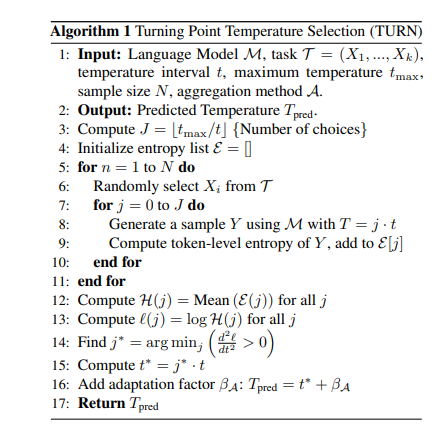

# Implementation

To run the code, please **enable the L4x4 GPU accelerator and internet connection** in the notebook on Kaggle.

**Kaggle notebook**: https://www.kaggle.com/code/ducnh279/optimize-temperature-for-llm-inference

**Reminder**: **Each (type of) model used for each task will have a different optimal temperature value**. For more details, I recommend reading the paper. 

The goal of this implementation is for my learning experience with a view to finding the **optimal temperature value** for the **Qwen2.5-0.5B-Instruct model** on the **GSM8K math dataset**.


It will takes about 3 hour to finish finding nearly optimal temperature value.

In [1]:
import os
import gc
import datasets
import random
import torch
import numpy as np

os.environ["CUDA_VISIBLE_DEVICES"] = "0,1"
os.environ["TOKENIZERS_PARALLELISM"] = "false"

In [2]:
from vllm import LLM, SamplingParams

llm_model_pth = '/kaggle/input/qwen2.5/transformers/0.5b-instruct/1'

llm = LLM(
    llm_model_pth,
    # quantization="awq",
    tensor_parallel_size=2,
    gpu_memory_utilization=0.90, 
    trust_remote_code=True,
    dtype="half", 
    enforce_eager=True,
    max_model_len=4096,
    disable_log_stats=True,
    max_logprobs=1000, 
)

tokenizer = llm.get_tokenizer()

WARNING 02-15 17:50:11 config.py:1668] Casting torch.bfloat16 to torch.float16.
INFO 02-15 17:50:33 config.py:905] Defaulting to use mp for distributed inference
WARNING 02-15 17:50:33 config.py:395] To see benefits of async output processing, enable CUDA graph. Since, enforce-eager is enabled, async output processor cannot be used
INFO 02-15 17:50:33 llm_engine.py:237] Initializing an LLM engine (v0.6.3.post1) with config: model='/kaggle/input/qwen2.5/transformers/0.5b-instruct/1', speculative_config=None, tokenizer='/kaggle/input/qwen2.5/transformers/0.5b-instruct/1', skip_tokenizer_init=False, tokenizer_mode=auto, revision=None, override_neuron_config=None, rope_scaling=None, rope_theta=None, tokenizer_revision=None, trust_remote_code=True, dtype=torch.float16, max_seq_len=4096, download_dir=None, load_format=LoadFormat.AUTO, tensor_parallel_size=2, pipeline_parallel_size=1, disable_custom_all_reduce=False, quantization=None, enforce_eager=True, kv_cache_dtype=auto, quantization_par

Loading safetensors checkpoint shards:   0% Completed | 0/1 [00:00<?, ?it/s]


(VllmWorkerProcess pid=350) INFO 02-15 17:51:23 model_runner.py:1067] Loading model weights took 0.4642 GB
INFO 02-15 17:51:23 model_runner.py:1067] Loading model weights took 0.4642 GB
INFO 02-15 17:51:25 distributed_gpu_executor.py:57] # GPU blocks: 193808, # CPU blocks: 43690
INFO 02-15 17:51:25 distributed_gpu_executor.py:61] Maximum concurrency for 4096 tokens per request: 757.06x


In [3]:
data = datasets.load_dataset('gsm8k', 'main')['train'].to_pandas()

README.md:   0%|          | 0.00/7.94k [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/2.31M [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/419k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/7473 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/1319 [00:00<?, ? examples/s]

In [4]:
def sample_prompts(num_samples, seed):
    math_problems = data['question'].sample(n=num_samples, random_state=seed).reset_index(drop=True)

    prefix_prompt = 'Please reason step by step to solve this problem:\n'

    prompts = []    
    for problem in math_problems:
        prompt = tokenizer.apply_chat_template(
            conversation=[{'role': 'user', 'content': prefix_prompt + problem}],
            tokenize=False,
            add_generation_prompt=True
        )
    
        prompts.append(prompt)

    return prompts

print(
    sample_prompts(num_samples=1, seed=318)
)

['<|im_start|>system\nYou are Qwen, created by Alibaba Cloud. You are a helpful assistant.<|im_end|>\n<|im_start|>user\nPlease reason step by step to solve this problem:\nAdam has 50 balls. 20 balls are red, 10 are blue, and the rest are either pink or orange. If there are 3 times as many pink as orange balls, how many orange balls are there?<|im_end|>\n<|im_start|>assistant\n']


In [5]:
temperature_candidates = np.arange(start=0.1, stop=1, step=0.1) # should tune the step size: 0.05, 0.1, 0.15 ... 

In [6]:
entropy_list = []

for temperature in temperature_candidates:
    
    # Using N = 300 samples to identify the turning point. - the more, the better
    prompts = sample_prompts(num_samples=300, seed=random.randint(0, 1000))
    
    sampling_params = SamplingParams(
        temperature=temperature, 
        max_tokens=1024, 
        logprobs=1000, # suggested by paper for reducing compuational overhead
    )

    model_outputs = llm.generate(prompts=prompts, sampling_params=sampling_params)
    entropy_values = []
    
    for i in range(len(prompts)):
        log_probabilities = model_outputs[i].outputs[0].logprobs
        entropy_per_token = []
        
        for token_logprobs in log_probabilities:
            token_entropy = []
            for logprob_entry in token_logprobs.values(): 
                token_entropy.append(logprob_entry.logprob * np.exp(logprob_entry.logprob))
            token_entropy = -sum(token_entropy)
            entropy_per_token.append(token_entropy)

        mean_entropy = sum(entropy_per_token) / len(entropy_per_token)
        entropy_values.append(mean_entropy)

    total_entropy = sum(entropy_values) / len(entropy_values)
    entropy_list.append(total_entropy)
    
    del model_outputs
    gc.collect()

Processed prompts: 100%|██████████| 300/300 [14:01<00:00,  2.80s/it, est. speed input: 35.71 toks/s, output: 113.17 toks/s]


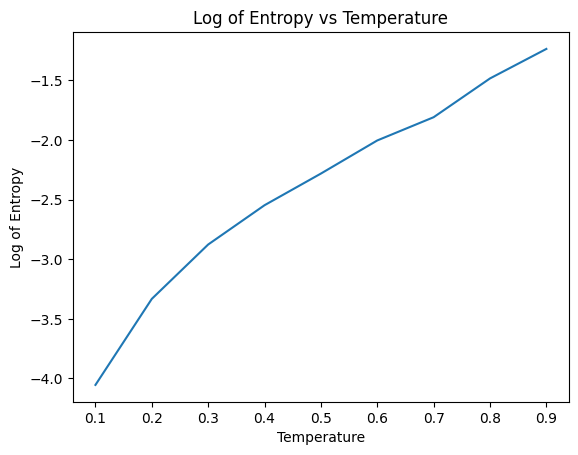

In [7]:
import matplotlib.pyplot as plt

log_entropy = np.log(entropy_list)

plt.plot(temperature_candidates, log_entropy)
plt.xlabel('Temperature')
plt.ylabel('Log of Entropy')
plt.title('Log of Entropy vs Temperature')
plt.show()

## To find the turning point, we find the point when second derivative of log entropy changes from negative to positive 

In [8]:
temperature_indicies = np.arange(
    len(temperature_candidates)
)

# Calculate the first derivative
dy_dx = np.gradient(temperature_indicies, log_entropy)

# Calculate the second derivative
d2y_dx2 = np.gradient(dy_dx, temperature_indicies)

print("dy_dx: ", dy_dx)
print("d2y_dx2: ", d2y_dx2)

d2y_dx2

dy_dx:  [1.38460664 1.87925757 2.67978435 3.43849578 3.68357908 4.49675603
 4.35751333 3.62002206 4.03668803]
d2y_dx2:  [ 0.49465093  0.64758885  0.77961911  0.50189736  0.52913012  0.33696713
 -0.43836698 -0.16041265  0.41666597]


array([ 0.49465093,  0.64758885,  0.77961911,  0.50189736,  0.52913012,
        0.33696713, -0.43836698, -0.16041265,  0.41666597])

In [9]:
optimal_temp_index = np.where(d2y_dx2 < 0)[0][0] 

print(f'The optimal temperature is located at index {optimal_temp_index} in the temperature candidates list.')

The optimal temperature is located at index 6 in the temperature candidates list.


In [10]:
optimal_temperature = temperature_candidates[optimal_temp_index]
print(f'The optimal temperature is {temperature_candidates[optimal_temp_index]} from the list of temperature candidates.')

The optimal temperature is 0.7000000000000001 from the list of temperature candidates.


We can now set the temperature to 0.7 to generate multiple response candidates and apply majority voting.